### Student Information
Name: 彭星樺

Student ID: 113065507

GitHub ID: ktpss97094

---

### Instructions

1. First: do the **take home** exercises in the [DM2024-Lab1-Master](https://github.com/didiersalazar/DM2024-Lab1-Master.git). You may need to copy some cells from the Lab notebook to this notebook. __This part is worth 20% of your grade.__


2. Second: follow the same process from the [DM2024-Lab1-Master](https://github.com/didiersalazar/DM2024-Lab1-Master.git) on **the new dataset**. You don't need to explain all details as we did (some **minimal comments** explaining your code are useful though).  __This part is worth 30% of your grade.__
    - Download the [the new dataset](https://huggingface.co/datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data). The dataset contains a `sentiment` and `comment` columns, with the sentiment labels being: 'nostalgia' and 'not nostalgia'. Read the specificiations of the dataset for background details. 
    - You are allowed to use and modify the `helper` functions in the folder of the first lab session (notice they may need modification) or create your own.


3. Third: please attempt the following tasks on **the new dataset**. __This part is worth 30% of your grade.__
    - Generate meaningful **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    - Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency). Refer to this Scikit-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .
    - Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Note that for the TF-IDF features you might need to use other type of NB classifier different than the one in the Master Notebook. Comment on the differences.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).


4. Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be handled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets? __This part is worth 10% of your grade.__


5. Fifth: It's hard for us to follow if your code is messy, so please **tidy up your notebook** and **add minimal comments where needed**. __This part is worth 10% of your grade.__


You can submit your homework following these guidelines: [Git Intro & How to hand your homework](https://github.com/didiersalazar/DM2024-Lab1-Master/blob/main/Git%20Intro%20%26%20How%20to%20hand%20your%20homework.ipynb). Make sure to commit and save your changes to your repository __BEFORE the deadline (October 27th 11:59 pm, Sunday)__. 

## Table of Contents
1. Data Preparation and Transformation
2. Data Mining using Pandas
 - 2.1 Dealing with Missing Values
 - 2.2 Dealing with Duplicate Data
3. Data Preprocessing
 - 3.1 Sampling
 - 3.2 Feature Creation
 - 3.3 Feature Subset Selection
 - 3.4 Atrribute Transformation / Aggregation
 - 3.5 Dimensionality Reduction
 - 3.6 Discretization and Binarization
4. Data Exploration
5. Data Classification

## Second Instruction

In [2]:
### Begin Assignment Here
%load_ext autoreload
%autoreload 2

%pip install fsspec
%pip install --upgrade huggingface_hub
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# categories
categories = ['not nostalgia', 'nostalgia']

In [4]:
'''
Read csv
'''
import pandas as pd

X = pd.read_csv("hf://datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv")

# Change column name
X.columns = ['category_name', *X.columns[1:]]

# Add numerical category
X['category'] = X['category_name'].apply(lambda x: 0 if x == categories[0] else 1)

In [5]:
'''
Some query methods
'''

X[:10][["comment","category"]]
X.loc[:10, 'comment']
X.iloc[:10, 0]
X.iat[0, 0]

'not nostalgia'

In [6]:
'''
Check missing values
'''
import helpers.data_mining_helpers as dmh

print("Dataframe missing record:")
display(X.isnull().apply(lambda x: dmh.check_missing_values(x)))

# insert two dummy records and remove it
pd.concat([X, pd.Series(["dummy_record_1", 0], index=["comment", "category"]).to_frame().T], ignore_index=True)  # insert panda Series
pd.concat([X, pd.DataFrame([{'comment': 'dummy_record_2',
               'category': 1
              }])], ignore_index=True)  # insert dataframe constructed from dict
X.dropna(inplace=True)  # remove missing value records

Dataframe missing record:


,category_name,comment,category
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


In [7]:
'''
Check duplicate records
'''

print(f"Original dataframe have {sum(X.duplicated())} duplicate records")

# remove duplicate records
X.drop_duplicates(keep=False, inplace=True)

Original dataframe have 1 duplicate records


<Axes: title={'center': 'Sampled Dataframe Category distribution'}, xlabel='category_name'>

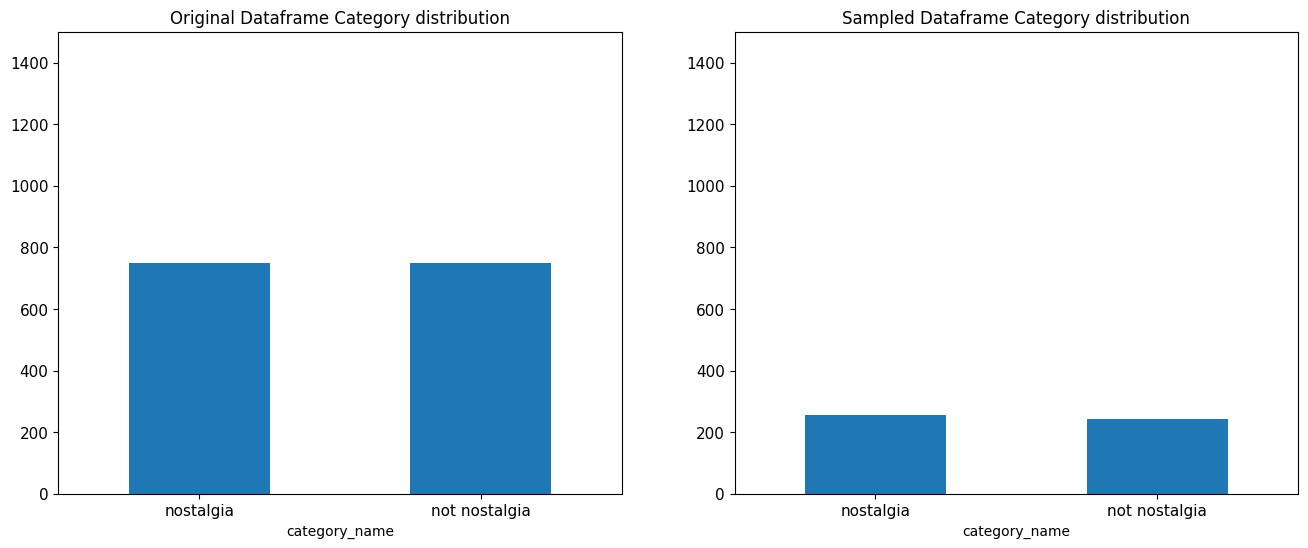

In [8]:
'''
Sampling
'''
import matplotlib.pyplot as plt
%matplotlib inline

X_sample = X.sample(n=500)

# Draw category distribution plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
X.category_name.value_counts().plot(kind = 'bar',
                                    title = 'Original Dataframe Category distribution',
                                    ylim = [0, 1500],        
                                    rot = 0, fontsize = 11, ax=ax[0])
X_sample.category_name.value_counts().plot(kind = 'bar',
                                    title = 'Sampled Dataframe Category distribution',
                                    ylim = [0, 1500],        
                                    rot = 0, fontsize = 11, ax=ax[1])

['00' '000' '045' ... 'yup' 'zealand' 'zulus']


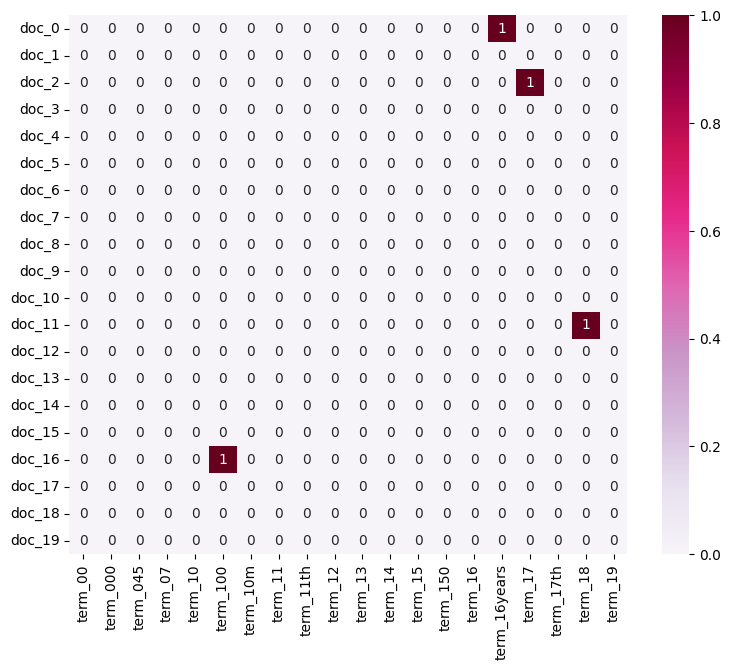

In [9]:
'''
Feature Creation
'''
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

# Tokenize text
X['unigrams'] = X['comment'].apply(lambda x: dmh.tokenize_text(x))

# Create term-document matrix (row: 每筆 record 的 document、col: 該 document 內的 term (word) count)
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.comment)
print(count_vect.get_feature_names_out())  # Get the word represented by each index of the word vector

# Tokenize text and remove stop words
analyze = count_vect.build_analyzer()
analyze(X.loc[0, "comment"])

# plot term-document matrix using seaborn
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[0:20]]
plot_y = ["doc_"+ str(i) for i in list(X.index)[0:20]]
plot_z = X_counts[0:20, 0:20].toarray()
df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=1, annot=True)

C:\Users\ktpss\AppData\Local\Temp\ipykernel_22232\2187377046.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90)


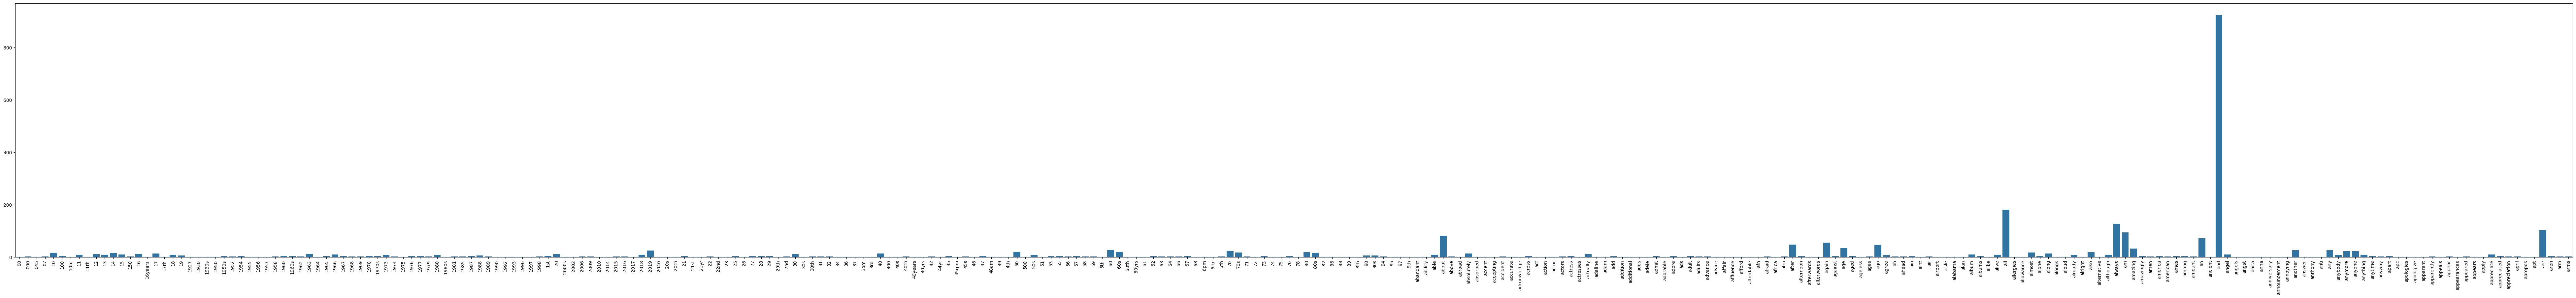

In [10]:
'''
Attribute Transformation / Aggregation
'''
import numpy as np
import plotly.express as px

# Calculate each term's frequency (in all documents)
term_frequencies = []
for j in range(0,X_counts.shape[1]):
    term_frequencies.append(sum(X_counts[:,j].toarray()))
term_frequencies = np.asarray(X_counts.sum(axis=0))[0]

# Plot term's frequency using matplotlib
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300], 
            y=term_frequencies[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90)

# Plot term's frequency using plotly
fig = px.bar(x=count_vect.get_feature_names_out()[:300], y=term_frequencies[:300])
fig.show()

In [11]:
'''
Filter top 5% and bottom 1% frequency words and save to csv
'''
from PAMI.extras.DF2DB import DenseFormatDF as db

'''
Create term_document_dfs
'''
categories = X['category_name'].unique()
category_dfs = {}
for category in categories:
    category_dfs[category] = X[X['category_name'] == category].copy()
def create_term_document_df(df):
    count_vect = CountVectorizer()
    X_counts = count_vect.fit_transform(df['comment'])
    words = count_vect.get_feature_names_out()
    term_document_df = pd.DataFrame(X_counts.toarray(), columns=words)
    return term_document_df
term_document_dfs = {}
for category in categories:
    term_document_dfs[category] = create_term_document_df(category_dfs[category])
 
'''
filter words
'''
def filter_top_bottom_words_by_sum(term_document_df, top_percent=0.05, bottom_percent=0.01):
    word_sums = term_document_df.sum(axis=0)
    
    sorted_words = word_sums.sort_values()
    
    total_words = len(sorted_words)
    top_n = int(top_percent * total_words)
    bottom_n = int(bottom_percent * total_words)
    
    words_to_remove = pd.concat([sorted_words.head(bottom_n), sorted_words.tail(top_n)]).index
    print(f'Bottom {bottom_percent*100}% words: \n{list(sorted_words.head(bottom_n).index)}')
    print(f'Top {top_percent*100}% words: \n{list(sorted_words.tail(top_n).index)}')
    return term_document_df.drop(columns=words_to_remove)

for category in categories:
    print(f'\nFor category {category} we filter the following words:')
    term_document_dfs[category] = filter_top_bottom_words_by_sum(term_document_dfs[category])

'''
save to csv
(
row i: document i's words excluding:
1. The top 5% most frequent words
2. The bottom 1% least frequent words
3. Words with a frequency of zero
)
'''
for category in term_document_dfs:
    category_safe = category.replace('.', '_')
    
    obj = db.DenseFormatDF(term_document_dfs[category])
    obj.convert2TransactionalDatabase(f'td_freq_db_{category}.csv', '>=', 1)


For category not nostalgia we filter the following words:
Bottom 1.0% words: 
['12', '16years', 'zealand', 'sensitive', 'sense', 'xd', 'wwii', 'wuv', 'writers', 'writer', 'wrenching', 'wouldn', '1998', 'measure', 'spine', 'spewing', '2040', '2018', '2017', '2010', '1957', '1955', '1952', '1930s', '1930', '17th']
Top 5.0% words: 
['first', 'got', 'classic', 'wish', 'any', 'make', 'or', 'come', 'did', 'those', 'why', 'way', 'then', 'god', 'sad', 'day', 'its', 'life', 'better', 'their', 'singing', 'nice', 'heart', 'real', 'years', 'were', 'than', 'sing', 'heard', 'listening', 'man', 'video', 'some', 'get', 'most', 'people', 'your', 'world', 'been', 'today', 'such', 'too', 'version', 'here', 'had', 'many', 'an', 'singer', 'do', 'hear', 'listen', 'old', 'up', 'these', 'could', 'him', 'out', 'there', 'am', 'very', 'has', 'don', 'how', 'still', 'only', 'thank', 'would', 'think', 'ever', 'by', 'best', 'we', 'if', 'more', 'really', 'who', 'never', 'about', 'much', 'now', 'know', 'no', 'good', 

Database size (total no of transactions) : 745
Number of items : 2446
Minimum Transaction Size : 1
Average Transaction Size : 8.405369127516778
Maximum Transaction Size : 47
Standard Deviation Transaction Size : 5.966526146738824
Variance in Transaction Sizes : 35.64728296168002
Sparsity : 0.9965636266853979
Database size (total no of transactions) : 734
Number of items : 2159
Minimum Transaction Size : 1
Average Transaction Size : 8.696185286103542
Maximum Transaction Size : 39
Standard Deviation Transaction Size : 7.20498326251217
Variance in Transaction Sizes : 51.982604800547186
Sparsity : 0.9959721235358483


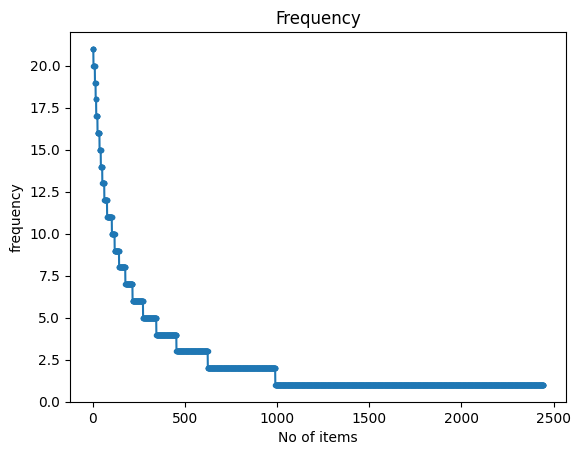

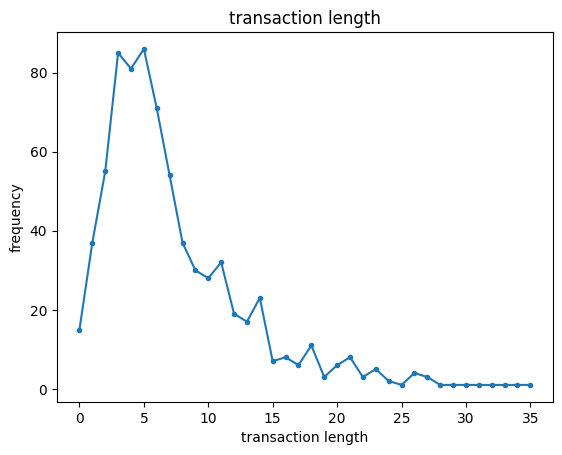

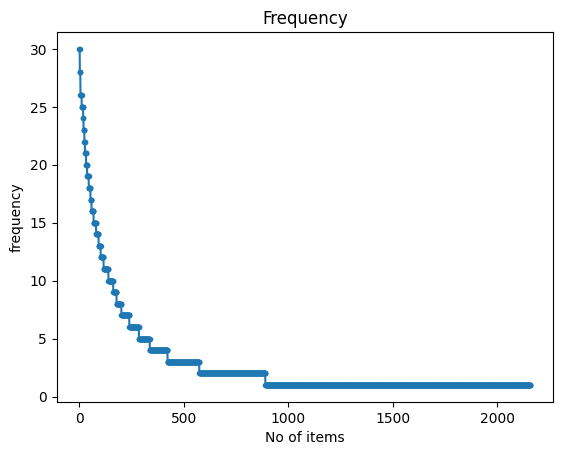

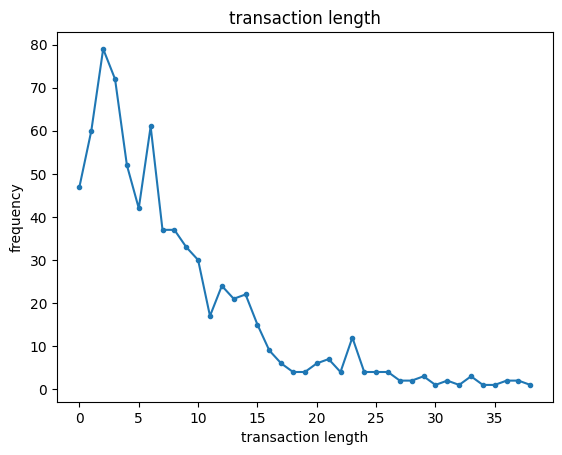

In [12]:
'''
Draw Item Frequency Distribution graph and Transaction Length Distribution graph

Item Frequency Distribution: x 依照 item 的 frequency 從小到大排序，每個 item 在幾個 transaction 中出現過
Transaction Length Distribution: 一個 category 中 transaction length 的分布
'''
from PAMI.extras.dbStats import TransactionalDatabase as tds

for category in term_document_dfs:
    obj = tds.TransactionalDatabase(f'td_freq_db_{category}.csv')
    obj.run()
    obj.printStats()
    obj.plotGraphs()

In [13]:
'''
Use FPGrowth to mining and get frequent patterns

pattern: 多個 term 同時出現在多個 document 中
'''
import pandas as pd
from PAMI.frequentPattern.basic import FPGrowth as alg
from sklearn.feature_extraction.text import CountVectorizer

minSup=9
dfs = []
for category in term_document_dfs:
    obj1 = alg.FPGrowth(iFile=f'td_freq_db_{category}.csv', minSup=minSup)
    obj1.mine()
    frequentPatternsDF= obj1.getPatternsAsDataFrame()
    
    print('Total No of patterns: ' + str(len(frequentPatternsDF)))
    print('Runtime: ' + str(obj1.getRuntime()))
    obj1.save(f'freq_patterns_{category}_minSup9.txt')

    dfs.append(frequentPatternsDF)

'''
Only reserve unique patterns in each category
'''
# Identify patterns that appear in more than one category
# Count how many times each pattern appears across all dataframes
pattern_counts = {}
for df in dfs:
    for pattern in df['Patterns']:
        if pattern not in pattern_counts:
            pattern_counts[pattern] = 1
        else:
            pattern_counts[pattern] += 1

# Filter out patterns that appear in more than one dataframe
unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}

total_patterns_count = sum(len(df) for df in dfs)
discarded_patterns_count = total_patterns_count - len(unique_patterns)

filtered_dfs = []
for df in dfs:
    filtered_df = df[df['Patterns'].isin(unique_patterns)]
    filtered_dfs.append(filtered_df)

final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)
final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)

'''
Construct pattern matrix and merge to original term-document matrix to "augmented dataframe"
'''
count_vect = CountVectorizer()
X_tdm = count_vect.fit_transform(X['comment'])
terms = count_vect.get_feature_names_out()

# Tokenize the sentences into sets of unique words
X['tokenized_text'] = X['comment'].str.split().apply(set)

# Initialize the pattern matrix
pattern_matrix = pd.DataFrame(0, index=X.index, columns=final_pattern_df['Patterns'])

# Iterate over each pattern and check if all words in the pattern are present in the tokenized sentence
for pattern in final_pattern_df['Patterns']:
    pattern_words = set(pattern.split())
    pattern_matrix[pattern] = X['tokenized_text'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

tdm_df = pd.DataFrame(X_tdm.toarray(), columns=terms, index=X.index)
augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1)

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 144
Runtime: 0.018624544143676758
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 180
Runtime: 0.005232572555541992


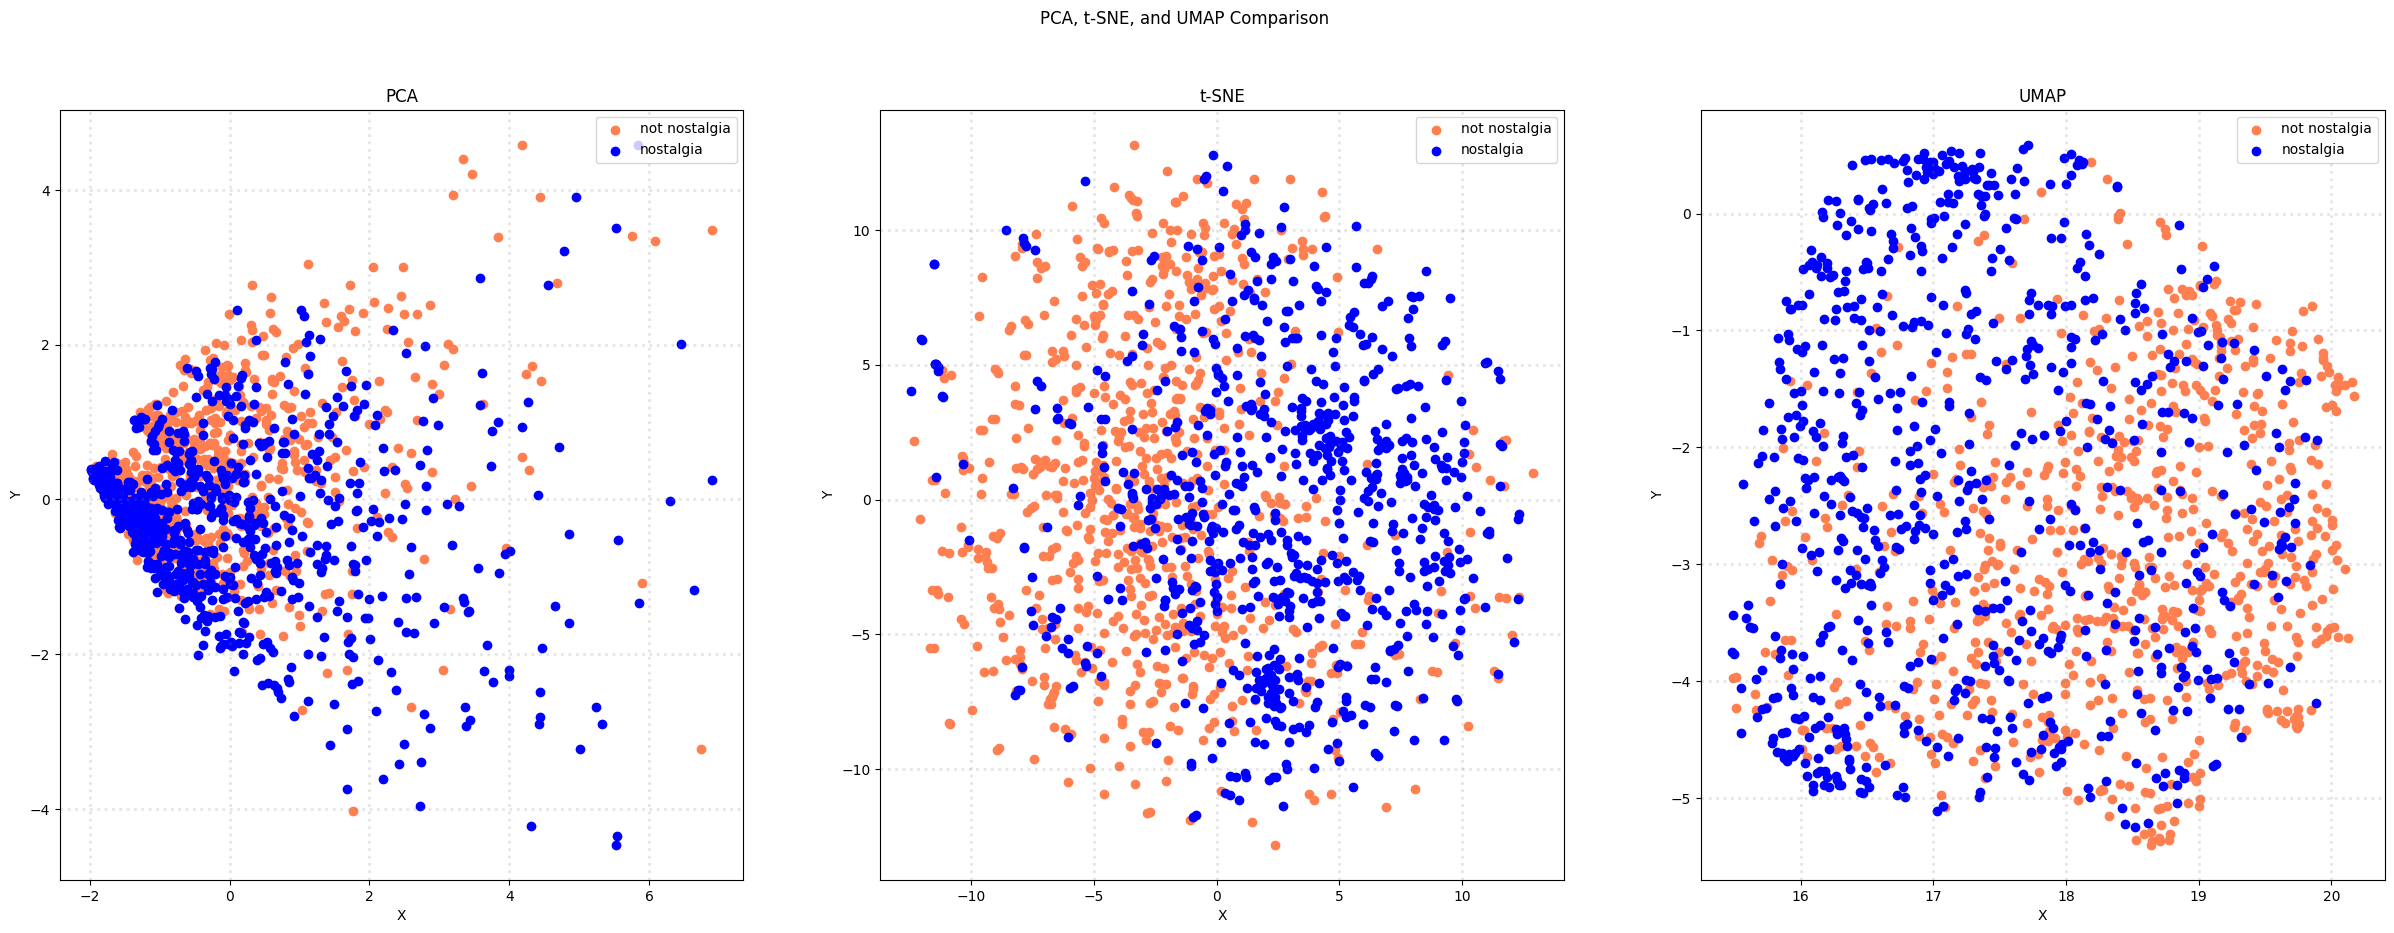

In [14]:
'''
Dimensionality Reduction
'''
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

# Dimensionality Reduction using PCA, t-SNE and UMAP
X_pca_aug = PCA(n_components=2).fit_transform(augmented_df.values)
X_tsne_aug = TSNE(n_components=2).fit_transform(augmented_df.values)
X_umap_aug = umap.UMAP(n_components=2).fit_transform(augmented_df.values)

# Plot
col = ['coral', 'blue', 'black', 'orange']
categories = X['category_name'].unique() 
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle('PCA, t-SNE, and UMAP Comparison')
def plot_scatter(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['category_name'] == category].T[0]
        ys = X_reduced[X['category_name'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')
plot_scatter(axes[0], X_pca_aug, 'PCA')
plot_scatter(axes[1], X_tsne_aug, 't-SNE')
plot_scatter(axes[2], X_umap_aug, 'UMAP')
plt.show()

In [15]:
'''
Discretization and Binarization
'''
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy

# Add binary category to original dataframe
mlb = preprocessing.LabelBinarizer()
mlb.fit(X.category)
X['bin_category'] = mlb.transform(X['category']).tolist()

In [16]:
'''
Data Exploration
'''
from sklearn.preprocessing import binarize
from sklearn.metrics.pairwise import cosine_similarity

# Compare document's similarity using Cosine Similarity
document_vector_count_1 = count_vect.transform([X.iloc[50]['comment']])
document_vector_count_2 = count_vect.transform([X.iloc[100]['comment']])
document_vector_count_3 = count_vect.transform([X.iloc[150]['comment']])
document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)
cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)
cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)
print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})
print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})

Cosine Similarity using count bw 1 and 2: 0.190347
Cosine Similarity using count bw 1 and 3: 0.027379
Cosine Similarity using count bw 2 and 3: 0.047946
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000


C:\Users\ktpss\AppData\Local\Temp\ipykernel_22232\1075616275.py:20: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\ktpss\AppData\Local\Temp\ipykernel_22232\1075616275.py:21: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\ktpss\AppData\Local\Temp\ipykernel_22232\1075616275.py:22: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\ktpss\AppData\Local\Temp\ipykernel_22232\1075616275.py:23: DeprecationWarning:

Conversion of an array with ndim > 0 t

In [17]:
'''
Data Classification
'''
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Classification using Naive Bayes Classifier
category_mapping = dict(X[['category', 'category_name']].drop_duplicates().values)
target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]
X_train, X_test, y_train, y_test = train_test_split(augmented_df, X['category'], test_size=0.3, random_state=42)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Accuracy: 0.8711111111111111

Classification Report:
                precision    recall  f1-score   support

not nostalgia     0.9238    0.8220    0.8700       236
    nostalgia     0.8250    0.9252    0.8722       214

     accuracy                         0.8711       450
    macro avg     0.8744    0.8736    0.8711       450
 weighted avg     0.8768    0.8711    0.8710       450



## Third Instruction

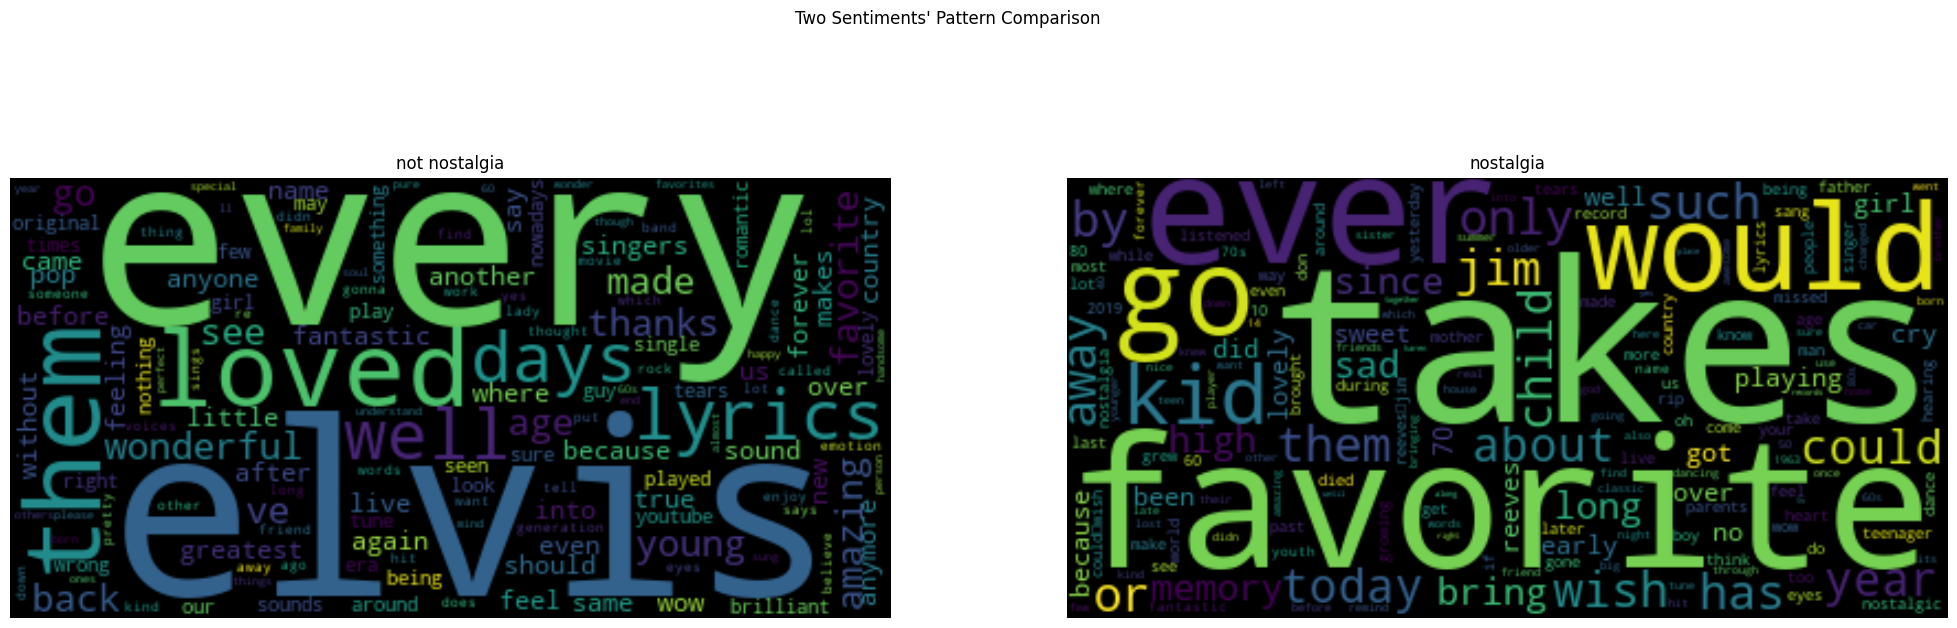

In [18]:
'''
New data visualization: word cloud
'''
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(25, 8))
fig.suptitle('Two Sentiments\' Pattern Comparison')

for i, category in enumerate(list(categories)):
    pattern_support_dict = {}

    with open(f'freq_patterns_{category}_minSup9.txt', 'r') as file:
        for line in file:
            key, value = line.strip().split(':')
            pattern_support_dict[key] = int(value)

    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=pattern_support_dict)

    axes[i].set_title(category)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")

plt.show()

In [33]:
'''
Generate TF-IDF features
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tdidf_vect = TfidfVectorizer()
X_tdidf = tdidf_vect.fit_transform(X.comment)
words = tdidf_vect.get_feature_names_out()

# Convert to dataframe
tfidf_term_document_df = pd.DataFrame(X_tdidf.toarray(), columns=words)

tfidf_term_document_df

,00,000,045,07,10,100,10m,11,11th,12,...,yours,yourself,youth,youthful,youtube,yrs,yuo,yup,zealand,zulus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
'''
Two Naive Bayes Classifier using TD-IDF and word frequency feature separately 
'''
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Original word frequency dataframe
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.comment)
words = count_vect.get_feature_names_out()
term_document_df = pd.DataFrame(X_counts.toarray(), columns=words)

category_mapping = dict(X[['category', 'category_name']].drop_duplicates().values)
target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]

X_train, X_test, y_train, y_test = train_test_split(term_document_df, X['category'], test_size=0.3, random_state=42)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)
print("Word frequency feature w/ MultinomialNB Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

X_train, X_test, y_train, y_test = train_test_split(tfidf_term_document_df, X['category'], test_size=0.3, random_state=42)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)
print("TD-IDF feature w/ GaussianNB Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Word frequency feature w/ MultinomialNB Accuracy: 0.8822222222222222

Classification Report:
                precision    recall  f1-score   support

not nostalgia     0.9463    0.8220    0.8798       236
    nostalgia     0.8286    0.9486    0.8845       214

     accuracy                         0.8822       450
    macro avg     0.8875    0.8853    0.8822       450
 weighted avg     0.8903    0.8822    0.8821       450

TD-IDF feature w/ GaussianNB Accuracy: 0.6511111111111111

Classification Report:
                precision    recall  f1-score   support

not nostalgia     0.7182    0.5508    0.6235       236
    nostalgia     0.6059    0.7617    0.6749       214

     accuracy                         0.6511       450
    macro avg     0.6621    0.6563    0.6492       450
 weighted avg     0.6648    0.6511    0.6480       450



In [ ]:
'''
Multinomial Naive Bayes Classifier uses multinomial distribution as the probability distribution, 
while Gaussian Naive Bayes Classifier uses Gaussian distribution as the probability distribution
'''

## Fourth Instruction

In DM2024-Lab1-Master, we didn't sampling before training the classifier. Putting all the records into training is inefficient. 

In addition, we can find different redundant words in different datasets. For example, the dataset "comp.graphics" has a lot of computer graphics reference articles and books attached with its ISBN. The dataset "alt.atheism" also has many atheism reference articles and books attached with its ISBN number. We can remove ISBNs in data preprocessing using regex ```ISBN [0-9]+-[^ ]*``` to find it simply. 
The dataset "soc.religion.christian", has a lot of bible quotations. We can also remove quotation numbers using regex ```[0-9]+:[0-9]+```.